# Tokenization, Vectorization, and Modeling
---

## 1) Imports

In [1]:
#Basic Modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Importing Data
import json

#Vectorization
import nltk
from nltk.corpus import stopwords
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

#Modeling
from sklearn import utils
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB

np.random.seed(42)

## 2) Reading in Chapter Data
---

In [2]:
with open("../corpora/chapter_text.json", "r") as json_file:
  chapter_text = json.load(json_file)
json_file.close()

In [3]:
#Inspecting imported data, keys have been converted to strings
chapter_text['1'].keys()

dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17'])

#### Converting chapter text into a Data Frame

In [4]:
chapter_data = [
    [book_num,chap,chapter_text[book_num][chap]]
    for book_num in chapter_text
    for chap in chapter_text[book_num]]
chapter_df = pd.DataFrame(data=chapter_data,columns=['book_number','chapter_number','chapter_text'])

In [5]:
len(chapter_data)

199

In [6]:
chapter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   book_number     199 non-null    object
 1   chapter_number  199 non-null    object
 2   chapter_text    199 non-null    object
dtypes: object(3)
memory usage: 4.8+ KB


In [7]:
#Converting book and chapter numbers back into integers
chapter_df['book_number'] = chapter_df['book_number'].astype(int)
chapter_df['chapter_number'] = chapter_df['chapter_number'].astype(int)

In [8]:
chapter_df.head()

,book_number,chapter_number,chapter_text
0,1,1,"Mr. and Mrs. Dursley, of number four, Privet D..."
1,1,2,Nearly ten years had passed since the Dursleys...
2,1,3,The escape of the Brazilian boa constrictor ea...
3,1,4,BOOM. They knocked again. Dudley jerked awake....
4,1,5,Harry woke early the next morning. Although he...


## 3) Baseline Model
---

### Establishing Null Model for Chapter Classification

In [9]:
pd.concat([chapter_df['book_number'].value_counts(normalize=False),
           chapter_df['book_number'].value_counts(normalize=True)],axis=1)

,book_number,book_number
5,38,0.190955
4,37,0.185930
7,37,0.185930
6,30,0.150754
3,22,0.110553
2,18,0.090452
1,17,0.085427


#### The baseline accuracy is 19.1% with the model predicting book five every time.

## 4) NLP Model
---

### Allocating training and test data

In [10]:
X = chapter_df['chapter_text']
y = chapter_df['book_number']

train, test = train_test_split(chapter_df, random_state=42, stratify=y)

In [11]:
len(train),len(test)

(149, 50)

In [12]:
#Number of words total
chapter_df['chapter_text'].apply(lambda x: len(x.split(' '))).sum()

1168327

In [13]:
#Making all text lowercase
chapter_df['chapter_text'] = chapter_df['chapter_text'].str.lower()

### Tokenizing

In [14]:
#train, test = train_test_split(df, test_size=0.3, random_state=42)
def tokenize_text(text):
    """
    Takes a string and tokenizes every word inside of it
    
    Paramaters:
    String text: A body of text 
    
    Return: List object of tokenized words taken from text paramater
    """
    tokens = []
    for sentence in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sentence):
            if len(word) < 2:
                continue #Skips words smaller than 2 characters
            tokens.append(word.lower())
    return tokens

### Document (chapter) Tagging

In [15]:
#tokenizes and tags each chapter, assigning the chapters' book number as the tag
train_tagged = train.apply(lambda r: TaggedDocument(words=tokenize_text(r['chapter_text']), tags=[r.book_number]), axis=1)
test_tagged = test.apply(lambda r: TaggedDocument(words=tokenize_text(r['chapter_text']), tags=[r.book_number]), axis=1)

In [16]:
#Testing tokens
tokens = tokenize_text("You're a wizard, Harry.")
TaggedDocument(words=tokens, tags=[1])

TaggedDocument(words=['you', "'re", 'wizard', 'harry'], tags=[1])

### Building vocabulary for our Distributed Bag of Words Doc2Vec model

In [17]:
#Each document vector will have a dimensionality of 100
dbow_model = Doc2Vec(dm=0, vector_size=100, negative=5, hs=0, min_count=2, sample = 0)
dbow_model.build_vocab([x for x in train_tagged.values])

### Training DBOW model with tagged training data

In [18]:
%%time
#Training Time
for epoch in range(30): #30 epochs
    dbow_model.train(utils.shuffle([x for x in train_tagged.values]), total_examples=len(train_tagged.values), epochs=1)
    dbow_model.alpha -= 0.002
    dbow_model.min_alpha = dbow_model.alpha

CPU times: user 39.5 s, sys: 437 ms, total: 40 s
Wall time: 14.3 s


#### Saving the Doc2Vec Model once it finishes training

In [19]:
#Giving the file name a minute-specific time-stamp to keep models unique and identifiable
import time
#Getting local time at the moment of cell execution
timestamp = time.localtime()

#Formatting Time
hour = f'{timestamp[3]:02d}'
minute = f'{timestamp[4]:02d}'
timestamp = f'{timestamp[0]}-{timestamp[1]}-{timestamp[2]}-{hour}-{minute}'

#Saving Model
dbow_model.save(f"../doc2vec_models/d2v_{timestamp}.model")
print(f"Time Saved: {timestamp}")

Time Saved: 2022-6-14-02-34


### Vectorizing the chapter text in the training and test data

In [20]:
def vec_for_learning(model, tagged_docs):
    """
    Uses the trained doc2vec model to map each tagged document in tagged_docs to a vector
    
    Parameters:
    gensim.models.doc2vec.Doc2Vec model: Trained Doc2Vec model
    pandas.core.series.Series (or other iterable) tagged_docs: iterable of gensim.models.doc2vec.TaggedDocument objects
    
    Return:
    Tuple targets: Target Value (Book number, integer) for the document, taken from the document tag
    Tuple regressors: Tuple containing np.ndarray representing vectorized document
    """
    sentences = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, epochs=20)) for doc in sentences])
    return targets, regressors

#Data types of function parameters
type(dbow_model),type(train_tagged[0])

(gensim.models.doc2vec.Doc2Vec, gensim.models.doc2vec.TaggedDocument)

In [21]:
#splititng the training and test data into target variables and vectorized documents
y_train, X_train = vec_for_learning(dbow_model, train_tagged)
y_test, X_test = vec_for_learning(dbow_model, test_tagged)

In [22]:
#100 dimension vector
X_train[0].shape

(100,)

## 5) Classification Models
---

#### The notebook output is starting to get long from all of the different confusion matricies, im implementing another task in the performance function which assigns the model name and its test f1 score to a dictionary of f1_scores to faciliate model comparisons.

In [23]:
f1_scores = {}

### Model Performance Display Function

In [24]:
def performance(model):
    """
    Takes in an Sklearn model and displays various performance metrics including a Confusion Matrix
    
    Paramaters:
    model: Sklearn model
    """
    model_name = str(model.__class__.__name__)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    f1_scores[model_name] = float('{:.4f}'.format(f1_score(y_test, test_preds, average='weighted')))
    
    # Score Displays
    print("_________________________________")
    print("Model Type: " + model_name)
    print("Evaluating Model Performance...\n")
    print('Train accuracy score:', accuracy_score(y_train, train_preds))
    print('Test accuracy score:', accuracy_score(y_test, test_preds),'\n')
    print('Train F1 score:', '{:.4f}'.format(f1_score(y_train, train_preds, average='weighted')))
    print('Test F1 score:', '{:.4f}'.format(f1_score(y_test, test_preds, average='weighted')))
    print("_________________________________")
    
    # Confusion Matrix
    plt.figure();
    ConfusionMatrixDisplay.from_estimator(model,X_test,y_test,cmap='Reds');
    plt.title(f'Confusion Matrix for {model_name}');
    plt.savefig(f'../visualizations/{model_name}.png')
    plt.show();
    pass

### Fitting various classification models and running the performance function on each to determine which one classifies chapters the most accurately.

_________________________________
Model Type: LogisticRegression
Evaluating Model Performance...

Train accuracy score: 0.31543624161073824
Test accuracy score: 0.24 

Train F1 score: 0.2278
Test F1 score: 0.1762
_________________________________


<Figure size 432x288 with 0 Axes>

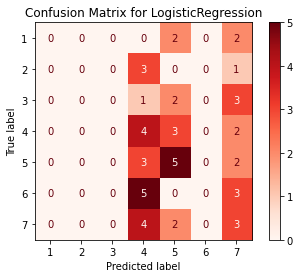

In [25]:
logreg = LogisticRegression(n_jobs=-1,C=0.0001,random_state=42)
logreg.fit(X_train, y_train)
performance(logreg)

_________________________________
Model Type: SVC
Evaluating Model Performance...

Train accuracy score: 0.3087248322147651
Test accuracy score: 0.22 

Train F1 score: 0.2221
Test F1 score: 0.1811
_________________________________


<Figure size 432x288 with 0 Axes>

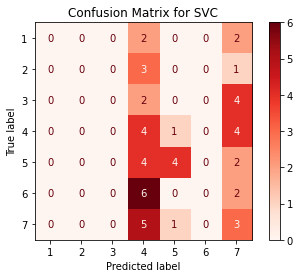

In [26]:
svc = SVC(random_state=42)
svc.fit(X_train, y_train)
performance(svc)

_________________________________
Model Type: KNeighborsClassifier
Evaluating Model Performance...

Train accuracy score: 0.3288590604026846
Test accuracy score: 0.3 

Train F1 score: 0.3070
Test F1 score: 0.2899
_________________________________


<Figure size 432x288 with 0 Axes>

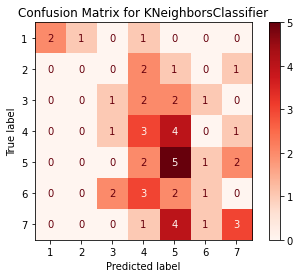

In [27]:
knn_class = KNeighborsClassifier(n_neighbors=10)
knn_class.fit(X_train, y_train)
performance(knn_class)

_________________________________
Model Type: DecisionTreeClassifier
Evaluating Model Performance...

Train accuracy score: 1.0
Test accuracy score: 0.14 

Train F1 score: 1.0000
Test F1 score: 0.1328
_________________________________


<Figure size 432x288 with 0 Axes>

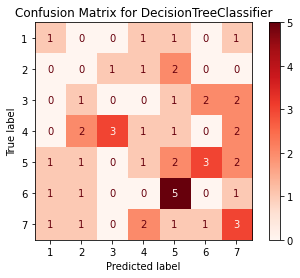

In [28]:
cart_class = DecisionTreeClassifier(random_state=42)
cart_class.fit(X_train, y_train)
performance(cart_class)

_________________________________
Model Type: BaggingClassifier
Evaluating Model Performance...

Train accuracy score: 0.9798657718120806
Test accuracy score: 0.2 

Train F1 score: 0.9799
Test F1 score: 0.1885
_________________________________


<Figure size 432x288 with 0 Axes>

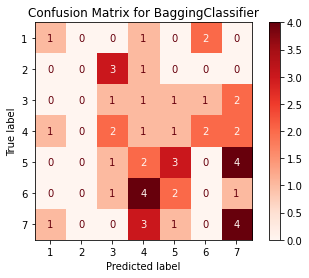

In [29]:
bagged_class = BaggingClassifier(random_state=42)
bagged_class.fit(X_train, y_train)
performance(bagged_class)

_________________________________
Model Type: RandomForestClassifier
Evaluating Model Performance...

Train accuracy score: 1.0
Test accuracy score: 0.26 

Train F1 score: 1.0000
Test F1 score: 0.2330
_________________________________


<Figure size 432x288 with 0 Axes>

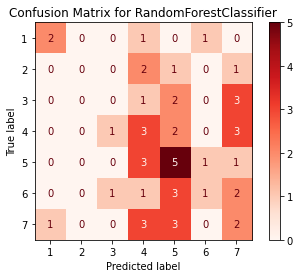

In [30]:
random_forest_class = RandomForestClassifier(random_state=42)
random_forest_class.fit(X_train, y_train)
performance(random_forest_class)

_________________________________
Model Type: AdaBoostClassifier
Evaluating Model Performance...

Train accuracy score: 0.348993288590604
Test accuracy score: 0.16 

Train F1 score: 0.3434
Test F1 score: 0.1479
_________________________________


<Figure size 432x288 with 0 Axes>

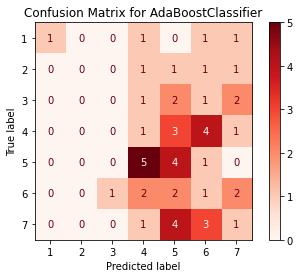

In [31]:
adaboost_class = AdaBoostClassifier(random_state=42)
adaboost_class.fit(X_train, y_train)
performance(adaboost_class)

_________________________________
Model Type: ExtraTreesClassifier
Evaluating Model Performance...

Train accuracy score: 1.0
Test accuracy score: 0.26 

Train F1 score: 1.0000
Test F1 score: 0.2405
_________________________________


<Figure size 432x288 with 0 Axes>

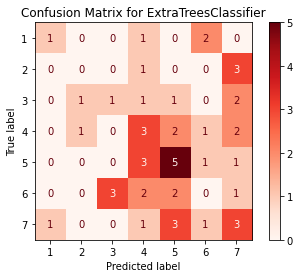

In [32]:
etc = ExtraTreesClassifier()
etc.fit(X_train, y_train)
performance(etc)

_________________________________
Model Type: GaussianNB
Evaluating Model Performance...

Train accuracy score: 0.5771812080536913
Test accuracy score: 0.14 

Train F1 score: 0.5720
Test F1 score: 0.1369
_________________________________


<Figure size 432x288 with 0 Axes>

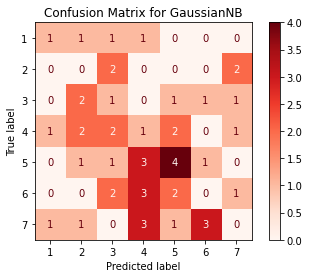

In [33]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
performance(gnb)

### Displaying a list of F1 Scores using the test data

In [34]:
import json
with open("../visualizations/f1_scores.json", "w") as json_file:
  json.dump(f1_scores, json_file)
json_file.close()
f1_scores

{'LogisticRegression': 0.1762,
 'SVC': 0.1811,
 'KNeighborsClassifier': 0.2899,
 'DecisionTreeClassifier': 0.1328,
 'BaggingClassifier': 0.1885,
 'RandomForestClassifier': 0.233,
 'AdaBoostClassifier': 0.1479,
 'ExtraTreesClassifier': 0.2405,
 'GaussianNB': 0.1369}

### Text Prediction Function (To be implemented as an app)

In [35]:
def predict_book(model,text):
    """
    Takes in a Sklearn model and any size string
    Tokenizes and vectorizes string
    Predicts which book the text is most likely to be in based on
    the vector created from the distributed bag of words model
    
    Parameters:
    Sklearn Model: model
    String: text
    
    returns: Book Number Prediction
    """
    tokens = tokenize_text(text)
    prediction = model.predict((dbow_model.infer_vector(tokens,epochs=20),))
    return prediction[0]

In [38]:
#Example
predict_book(knn_class,"The goblet of fire")

4

### Bonus: Similarity Score Analysis with the Doc2Vec Model

In [40]:
#Returns top similarity score for each book
for i in range(1,8):
    sim = dbow_model.dv.most_similar(positive=i)[0]
    print(f"The book most similar to Book {i} is Book {sim[0]} with a similarity score of {sim[1]}", )

The book most similar to Book 1 is Book 4 with a similarity score of 0.8966854810714722
The book most similar to Book 2 is Book 7 with a similarity score of 0.9074156284332275
The book most similar to Book 3 is Book 6 with a similarity score of 0.9286062717437744
The book most similar to Book 4 is Book 7 with a similarity score of 0.9340763688087463
The book most similar to Book 5 is Book 7 with a similarity score of 0.9393233060836792
The book most similar to Book 6 is Book 5 with a similarity score of 0.9291275143623352
The book most similar to Book 7 is Book 5 with a similarity score of 0.9393232464790344
